帧间差法进行关键帧提取
提取出来的内容存储在 ../data 目录下

C:\Users\杨大宇\AppData\Local\Programs\Python\Python311\python.exe
target video :E:\Celeb-DF-v2\Celeb-real\id0_0000.mp4
frame save directory: ./output/
Using Local Maxima


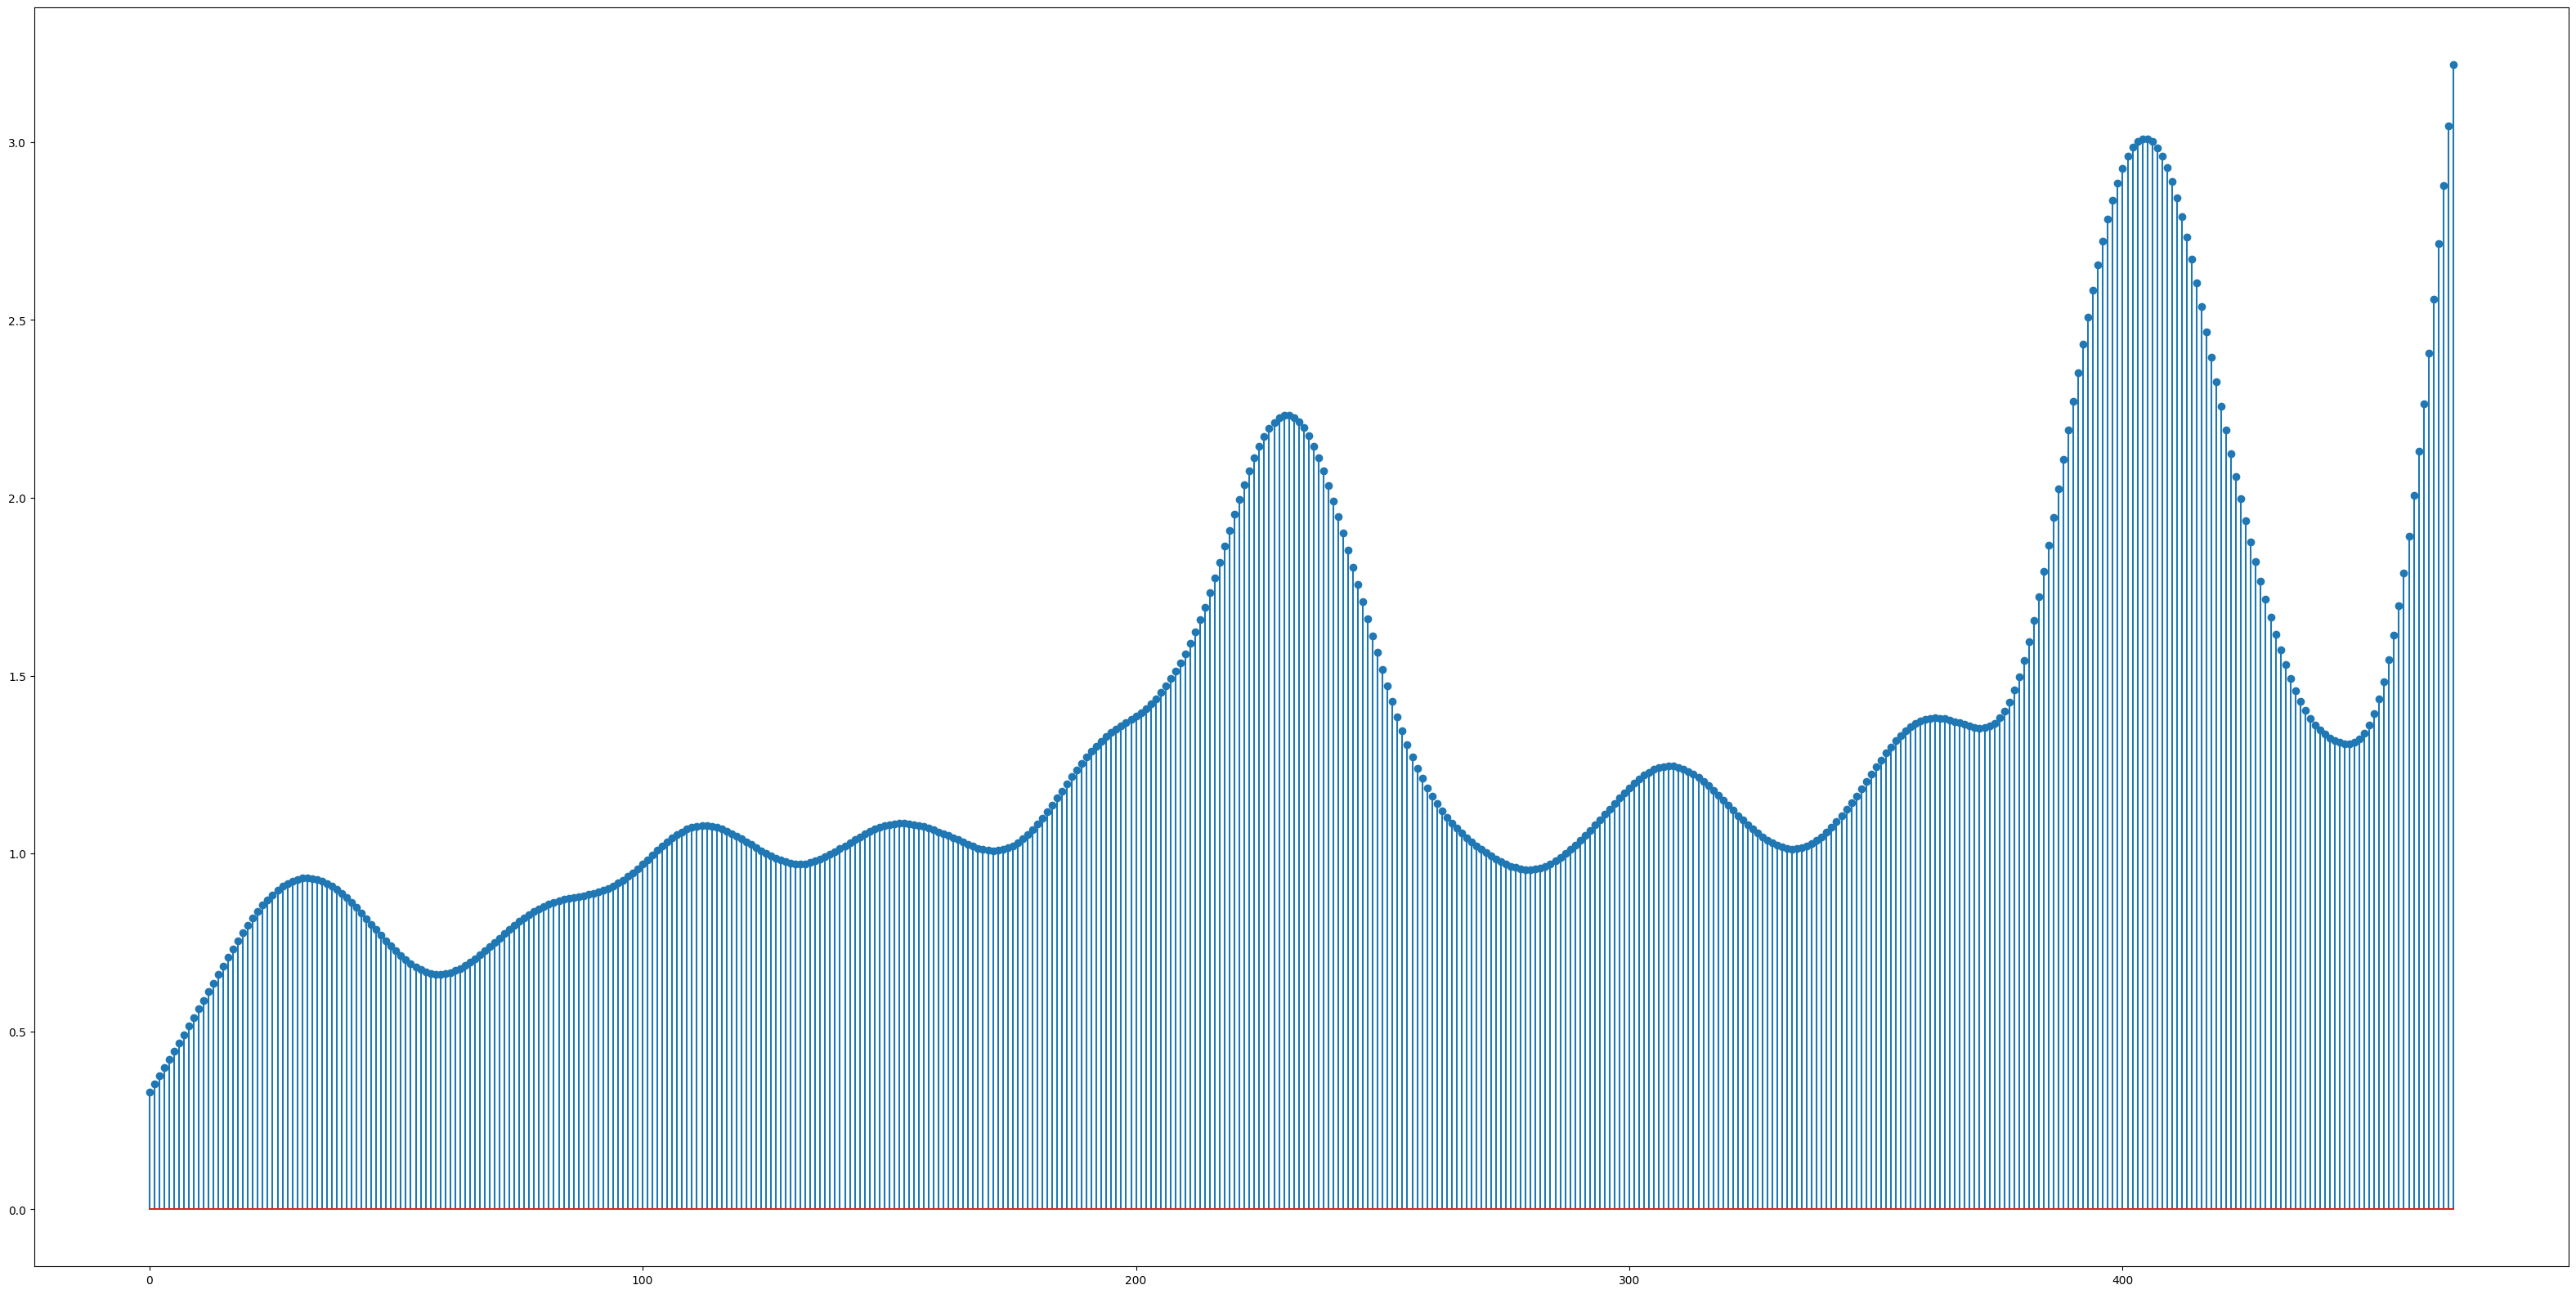

In [2]:
import os
import cv2
import operator
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.signal import argrelextrema

def smooth(x, window_len=13, window='hanning'):
    s = np.r_[2 * x[0] - x[window_len:1:-1], x, 2 * x[-1] - x[-1:-window_len:-1]]
    if window == 'flat':
        w = np.ones(window_len, 'd')
    else:
        w = getattr(np, window)(window_len)
    y = np.convolve(w / w.sum(), s, mode='same')
    return y[window_len - 1:-window_len + 1]

class Frame:
    def __init__(self, id, diff):
        self.id = id
        self.diff = diff

    def __lt__(self, other):
        return self.id < other.id

    def __gt__(self, other):
        return other.__lt__(self)

    def __eq__(self, other):
        return self.id == other.id and self.id == other.id

    def __ne__(self, other):
        return not self.__eq__(other)

def rel_change(a, b):
   x = (b - a) / max(a, b)
   return x

if __name__ == "__main__":
    print(sys.executable)
    USE_THRESH = False
    THRESH = 0.6
    USE_TOP_ORDER = False
    USE_LOCAL_MAXIMA = True
    NUM_TOP_FRAMES = 50

    videopath = 'E:\Celeb-DF-v2\Celeb-real\id0_0000.mp4'
    dir = './output/'
    len_window = int(50)

    if not os.path.exists(dir):
        os.makedirs(dir)

    print("target video :" + videopath)
    print("frame save directory: " + dir)
    cap = cv2.VideoCapture(str(videopath))
    curr_frame = None
    prev_frame = None
    frame_diffs = []
    frames = []
    success, frame = cap.read()
    i = 0
    while(success):
        luv = cv2.cvtColor(frame, cv2.COLOR_BGR2LUV)
        curr_frame = luv
        if curr_frame is not None and prev_frame is not None:
            diff = cv2.absdiff(curr_frame, prev_frame)
            diff_sum = np.sum(diff)
            diff_sum_mean = diff_sum / (diff.shape[0] * diff.shape[1])
            frame_diffs.append(diff_sum_mean)
            frame = Frame(i, diff_sum_mean)
            frames.append(frame)
        prev_frame = curr_frame
        i = i + 1
        success, frame = cap.read()
    cap.release()

    keyframe_id_set = set()
    if USE_TOP_ORDER:
        frames.sort(key=operator.attrgetter("diff"), reverse=True)
        for keyframe in frames[:NUM_TOP_FRAMES]:
            keyframe_id_set.add(keyframe.id)
    if USE_THRESH:
        print("Using Threshold")
        for i in range(1, len(frames)):
            if (rel_change(np.float(frames[i - 1].diff), np.float(frames[i].diff)) >= THRESH):
                keyframe_id_set.add(frames[i].id)
    if USE_LOCAL_MAXIMA:
        print("Using Local Maxima")
        diff_array = np.array(frame_diffs)
        sm_diff_array = smooth(diff_array, len_window)
        frame_indexes = np.asarray(argrelextrema(sm_diff_array, np.greater))[0]
        for i in frame_indexes:
            keyframe_id_set.add(frames[i - 1].id)

        plt.figure(figsize=(40, 20))
        plt.stem(sm_diff_array)
        plt.savefig(os.path.join(dir, 'plot.png'))

    cap = cv2.VideoCapture(str(videopath))
    curr_frame = None
    keyframes = []
    success, frame = cap.read()
    idx = 0
    while(success):
        if idx in keyframe_id_set:
            name = "keyframe_" + str(idx) + ".jpg"
            cv2.imwrite(os.path.join(dir, name), frame)
            keyframe_id_set.remove(idx)
        idx = idx + 1
        success, frame = cap.read()
    cap.release()


In [2]:
import os
import cv2
import operator
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.signal import argrelextrema

def smooth(x, window_len=13, window='hanning'):
    s = np.r_[2 * x[0] - x[window_len:1:-1], x, 2 * x[-1] - x[-1:-window_len:-1]]
    if window == 'flat':
        w = np.ones(window_len, 'd')
    else:
        w = getattr(np, window)(window_len)
    y = np.convolve(w / w.sum(), s, mode='same')
    return y[window_len - 1:-window_len + 1]

class Frame:
    def __init__(self, id, diff):
        self.id = id
        self.diff = diff

    def __lt__(self, other):
        return self.id < other.id

    def __gt__(self, other):
        return other.__lt__(self)

    def __eq__(self, other):
        return self.id == other.id and self.id == other.id

    def __ne__(self, other):
        return not self.__eq__(other)

def rel_change(a, b):
   x = (b - a) / max(a, b)
   return x
# Assuming Frame and other necessary functions are defined elsewhere

def process_video(videopath, output_dir):
    USE_THRESH = False
    THRESH = 0.6
    USE_TOP_ORDER = False
    USE_LOCAL_MAXIMA = True
    NUM_TOP_FRAMES = 50
    len_window = int(50)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Processing video: " + videopath)
    cap = cv2.VideoCapture(videopath)
    curr_frame = None
    prev_frame = None
    frame_diffs = []
    frames = []
    success, frame = cap.read()
    i = 0

    while success:
        luv = cv2.cvtColor(frame, cv2.COLOR_BGR2LUV)
        curr_frame = luv
        if curr_frame is not None and prev_frame is not None:
            diff = cv2.absdiff(curr_frame, prev_frame)
            diff_sum = np.sum(diff)
            diff_sum_mean = diff_sum / (diff.shape[0] * diff.shape[1])
            frame_diffs.append(diff_sum_mean)
            frame = Frame(i, diff_sum_mean)  # Ensure Frame class is defined
            frames.append(frame)
        prev_frame = curr_frame
        i += 1
        success, frame = cap.read()

    cap.release()

    keyframe_id_set = set()
    if USE_TOP_ORDER:
        frames.sort(key=operator.attrgetter("diff"), reverse=True)
        for keyframe in frames[:NUM_TOP_FRAMES]:
            keyframe_id_set.add(keyframe.id)

    if USE_THRESH:
        print("Using Threshold")
        for i in range(1, len(frames)):
            if (rel_change(np.float(frames[i - 1].diff), np.float(frames[i].diff)) >= THRESH):
                keyframe_id_set.add(frames[i].id)

    if USE_LOCAL_MAXIMA:
        print("Using Local Maxima")
        diff_array = np.array(frame_diffs)
        sm_diff_array = smooth(diff_array, len_window)  # Ensure smooth function is defined
        frame_indexes = np.asarray(argrelextrema(sm_diff_array, np.greater))[0]
        for i in frame_indexes:
            keyframe_id_set.add(frames[i - 1].id)


    cap = cv2.VideoCapture(videopath)
    curr_frame = None
    keyframes = []
    success, frame = cap.read()
    idx = 0
    while success:
        if idx in keyframe_id_set:
            name = filename + '_' + str(idx) + ".jpg"
            # name = f"keyframe_{count}.jpg"
            cv2.imwrite(os.path.join(output_dir, name), frame)
            keyframe_id_set.remove(idx)
        idx += 1
        success, frame = cap.read()

    cap.release()

if __name__ == "__main__":
    # cnt = 0
    input_folder = 'data/mp4'  # Update to your input folder
    output_folder = 'data/img/0'

    for filename in os.listdir(input_folder):
        if filename.endswith('.mp4'):  # Process only .mp4 files
            videopath = os.path.join(input_folder, filename)
            process_video(videopath, output_folder)
            # cnt = cnt + 1
        # if cnt == 900:
        #     break


Processing video: data/mp4\1-KMEANS算法概述_哔哩哔哩_bilibili.mp4
Using Local Maxima
Processing video: data/mp4\1-Kmeans算法模块概述_哔哩哔哩_bilibili.mp4
Using Local Maxima


KeyboardInterrupt: 

In [1]:
import os
import cv2
import operator
import numpy as np
from scipy.signal import argrelextrema

def smooth(x, window_len=13, window='hanning'):
    s = np.r_[2 * x[0] - x[window_len:1:-1], x, 2 * x[-1] - x[-1:-window_len:-1]]
    if window == 'flat':
        w = np.ones(window_len, 'd')
    else:
        w = getattr(np, window)(window_len)
    y = np.convolve(w / w.sum(), s, mode='same')
    return y[window_len - 1:-window_len + 1]

class Frame:
    def __init__(self, id, diff):
        self.id = id
        self.diff = diff

    def __lt__(self, other):
        return self.id < other.id

    def __eq__(self, other):
        return self.id == other.id

def rel_change(a, b):
    return (b - a) / max(a, b) if max(a, b) != 0 else 0

def process_video(videopath, output_dir):
    USE_THRESH = True
    THRESH = 1
    USE_TOP_ORDER = False
    USE_LOCAL_MAXIMA = False
    NUM_TOP_FRAMES = 50
    len_window = 50
    min_gap = 100  # 设置关键帧最小间隔

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Processing video: " + videopath)
    cap = cv2.VideoCapture(videopath)
    frame_diffs = []
    frames = []
    success, frame = cap.read()
    i = 0

    while success:
        luv = cv2.cvtColor(frame, cv2.COLOR_BGR2LUV)
        if i > 0:  # 跳过第一帧
            diff = cv2.absdiff(luv, prev_frame)
            diff_sum_mean = np.mean(diff)
            frame_diffs.append(diff_sum_mean)
            frames.append(Frame(i, diff_sum_mean))
        prev_frame = luv
        success, frame = cap.read()
        i += 1

    cap.release()

    keyframe_id_set = set()

    if USE_TOP_ORDER:
        frames.sort(key=operator.attrgetter("diff"), reverse=True)
        selected_count = 0
        last_selected_index = -min_gap  # 初始化为负值
        for keyframe in frames:
            if keyframe.id - last_selected_index >= min_gap:  # 确保间隔大于 min_gap
                keyframe_id_set.add(keyframe.id)
                last_selected_index = keyframe.id
                selected_count += 1
                if selected_count >= NUM_TOP_FRAMES:  # 限制数量
                    break

    if USE_THRESH:
        print("Using Threshold")
        last_selected_index = -1  # 初始化
        for i in range(1, len(frames)):
            if rel_change(frames[i - 1].diff, frames[i].diff) >= THRESH and (i - last_selected_index > min_gap):
                keyframe_id_set.add(frames[i].id)
                last_selected_index = i

    if USE_LOCAL_MAXIMA:
        print("Using Local Maxima")
        diff_array = np.array(frame_diffs)
        sm_diff_array = smooth(diff_array, len_window)
        frame_indexes = np.asarray(argrelextrema(sm_diff_array, np.greater))[0]

        last_index = -min_gap  # 初始化为负值
        for i in frame_indexes:
            if i - last_index >= min_gap:  # 确保间隔大于 min_gap
                keyframe_id_set.add(frames[i - 1].id)
                last_index = i

    cap = cv2.VideoCapture(videopath)
    success, frame = cap.read()
    idx = 0
    while success:
        if idx in keyframe_id_set:
            name = f"{os.path.splitext(filename)[0]}_{idx}.jpg"
            full_path = os.path.join(output_dir, name)

            # 处理文件名编码，确保不乱码
            cv2.imwrite(full_path.encode('utf-8').decode('utf-8'), frame)
            keyframe_id_set.remove(idx)
        idx += 1
        success, frame = cap.read()

    cap.release()

    # cap = cv2.VideoCapture(videopath)
    # success, frame = cap.read()
    # idx = 0
    # while success:
    #     if idx in keyframe_id_set:
    #         name = f"{os.path.splitext(filename)[0]}_{idx}.jpg"
    #         cv2.imwrite(os.path.join(output_dir, name), frame)
    #         keyframe_id_set.remove(idx)
    #     idx += 1
    #     success, frame = cap.read()
    #
    # cap.release()

if __name__ == "__main__":
    input_folder = 'E:\DL\data\MP4\猴博士高数（MP4）'  # 更新为你的输入文件夹
    output_folder = 'E:\DL\data\MP4\houBoshi_img'

    for filename in os.listdir(input_folder):
        if filename.endswith('.mp4'):
            videopath = os.path.join(input_folder, filename)
            process_video(videopath, output_folder)


Processing video: E:\DL\data\MP4\猴博士高数（MP4）\剩余视频_哔哩哔哩_bilibili.mp4
Using Threshold
Processing video: E:\DL\data\MP4\猴博士高数（MP4）\极限第1课【求直接代入型的极限】_哔哩哔哩_bilibili.mp4
Using Threshold
Processing video: E:\DL\data\MP4\猴博士高数（MP4）\极限第2课【求∞／∞的极限】_哔哩哔哩_bilibili.mp4


KeyboardInterrupt: 